In [1]:
!git clone https://github.com/sorki/python-mnist
!./python-mnist/bin/mnist_get_data.sh
!pip3 install emnist keras-tuner
from emnist import extract_training_samples

print("Imported the EMNIST libraries we need!")

Cloning into 'python-mnist'...
remote: Enumerating objects: 240, done.
remote: Total 240 (delta 0), reused 0 (delta 0), pack-reused 240
Receiving objects: 100% (240/240), 44.93 KiB | 4.08 MiB/s, done.
Resolving deltas: 100% (118/118), done.
--2021-03-19 15:07:20--  http://yann.lecun.com/exdb/mnist/
Resolving yann.lecun.com (yann.lecun.com)... 172.67.171.76, 104.21.29.36, 2606:4700:3036::ac43:ab4c, ...
Connecting to yann.lecun.com (yann.lecun.com)|172.67.171.76|:80... connected.
HTTP request sent, awaiting response... 503 Service Unavailable
2021-03-19 15:07:21 ERROR 503: Service Unavailable.

/content/data /content
gzip: *.gz: No such file or directory
/content
     |████████████████████████████████| 71kB 4.8MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2-cp37-none-any.whl size=78938 sha256=9d41d24f2dca8780b6402129be2154034b5d0beb633c32d0fd6d482ef1749b30
  Stored in directory: /root/.cache/pip/wheels/bb/a1/8a/7c3de0efb3707a1701b36ebbfdbc4e67aedf6d4943a1f463d6
  Create

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from keras.layers import *
from keras.models import *
from keras.optimizers import *
from keras.utils import to_categorical
from emnist import extract_training_samples, extract_test_samples


from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

import kerastuner

In [3]:
# Note: If you are using the Google Colab, test the GPU source 

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Fri Mar 19 15:07:29 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [37]:
train_X, train_y = extract_training_samples("letters");
test_X, test_y = extract_test_samples("letters");

# Normalise
train_X = train_X.astype('float32')
train_X /= 255
test_X = test_X.astype('float32')
test_X /= 255

#train_X, val_X, train_y, val_y = train_test_split(images, labels, test_size= 0.10, random_state=42)


In [38]:
# Reshape image for CNN
train_X = train_X.reshape(-1, 28, 28, 1)
test_X = test_X.reshape(-1, 28, 28, 1)

num_classes = np.unique(train_y)
train_y = to_categorical(train_y)
test_y = to_categorical(test_y)

train_y = np.delete(train_y, 0, axis=1)
test_y = np.delete(test_y, 0, axis=1)

In [39]:
def model_builder(hp):
    model = keras.Sequential()
    hp_filters = hp.Choice('filters', values=[32, 64, 128])
    hp_kernel_size = hp.Choice('kernel_size', values=[3, 5])
    hp_dropout_rate = hp.Float('rate', min_value=0, max_value=0.5, step=0.1)
    model.add(Conv2D(filters=hp_filters, kernel_size=hp_kernel_size, activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(rate=hp_dropout_rate))
    model.add(Conv2D(filters=hp_filters*2, kernel_size=hp_kernel_size, activation='relu', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(rate=hp_dropout_rate))
    model.add(Flatten())
    hp_units = hp.Choice('units', values=[64, 128, 256, 512, 1024])
    model.add(Dense(units=hp_units, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(rate=hp_dropout_rate))
    model.add(Dense(26, activation='softmax'))  


    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

    return model

In [40]:
tuner = kerastuner.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='hp-custom-model-letters')
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(train_X, train_y, epochs=50, validation_split=0.2, callbacks=[stop_early])


Trial 30 Complete [00h 01m 25s]
val_accuracy: 0.038701921701431274

Best val_accuracy So Far: 0.941987156867981
Total elapsed time: 00h 24m 33s
INFO:tensorflow:Oracle triggered exit


In [41]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]


In [ ]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
checkpoint_filepath = './checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

cb_list = [model_checkpoint_callback, early_stop]
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_X, train_y, epochs=50, validation_split=0.2, callbacks=cb_list)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))


Epoch 1/50
6000/6000 [==============================] - 22s 4ms/step - loss: 0.5209 - accuracy: 0.8354 - val_loss: 0.0536 - val_accuracy: 0.9837
Epoch 2/50
6000/6000 [==============================] - 22s 4ms/step - loss: 0.0685 - accuracy: 0.9795 - val_loss: 0.0306 - val_accuracy: 0.9907
Epoch 3/50
6000/6000 [==============================] - 22s 4ms/step - loss: 0.0453 - accuracy: 0.9862 - val_loss: 0.0245 - val_accuracy: 0.9928
Epoch 4/50
6000/6000 [==============================] - 22s 4ms/step - loss: 0.0343 - accuracy: 0.9897 - val_loss: 0.0210 - val_accuracy: 0.9938
Epoch 5/50
6000/6000 [==============================] - 22s 4ms/step - loss: 0.0289 - accuracy: 0.9913 - val_loss: 0.0189 - val_accuracy: 0.9943
Epoch 6/50
6000/6000 [==============================] - 21s 4ms/step - loss: 0.0254 - accuracy: 0.9920 - val_loss: 0.0193 - val_accuracy: 0.9942
Epoch 7/50
6000/6000 [==============================] - 22s 4ms/step - loss: 0.0238 - accuracy: 0.9928 - val_loss: 0.0171 - val_ac

In [ ]:
print(f" filters: {best_hps.get('filters')} \n kernel_size: {best_hps.get('kernel_size')} \n dropout_rate:{best_hps.get('rate')} \n units:{best_hps.get('units')}")

 filters: 32 
 kernel_size: 5 
 dropout_rate:0.30000000000000004 
 units:512


In [ ]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(train_X, train_y, epochs=best_epoch, validation_split=0.2)


Epoch 1/30
6000/6000 [==============================] - 22s 4ms/step - loss: 0.5055 - accuracy: 0.8418 - val_loss: 0.0473 - val_accuracy: 0.9859
Epoch 2/30
6000/6000 [==============================] - 21s 4ms/step - loss: 0.0668 - accuracy: 0.9800 - val_loss: 0.0311 - val_accuracy: 0.9906
Epoch 3/30
6000/6000 [==============================] - 22s 4ms/step - loss: 0.0458 - accuracy: 0.9863 - val_loss: 0.0250 - val_accuracy: 0.9924
Epoch 4/30
6000/6000 [==============================] - 22s 4ms/step - loss: 0.0362 - accuracy: 0.9890 - val_loss: 0.0219 - val_accuracy: 0.9938
Epoch 5/30
6000/6000 [==============================] - 21s 4ms/step - loss: 0.0295 - accuracy: 0.9907 - val_loss: 0.0204 - val_accuracy: 0.9936
Epoch 6/30
6000/6000 [==============================] - 21s 4ms/step - loss: 0.0260 - accuracy: 0.9922 - val_loss: 0.0181 - val_accuracy: 0.9945
Epoch 7/30
6000/6000 [==============================] - 21s 4ms/step - loss: 0.0237 - accuracy: 0.9929 - val_loss: 0.0168 - val_ac

In [ ]:
eval_result = hypermodel.evaluate(test_X, test_y)
print("[test loss, test accuracy]:", eval_result)


1250/1250 [==============================] - 3s 2ms/step - loss: 0.0142 - accuracy: 0.9963
[test loss, test accuracy]: [0.014162015169858932, 0.9963499903678894]


In [ ]:
# Retrieve the best model.
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model.
eval_result_best = best_model.evaluate(test_X, test_y)
print("[test loss, test accuracy]:", eval_result_best)

1250/1250 [==============================] - 3s 2ms/step - loss: 0.0171 - accuracy: 0.9949
[test loss, test accuracy]: [0.016333704814314842, 0.9948999881744385]


In [ ]:
hypermodel.save('custom_model_digits.h5')

In [ ]:
history.history['val_accuracy']

[0.9836666584014893,
 0.9907083511352539,
 0.9928333163261414,
 0.9938125014305115,
 0.9943333268165588,
 0.9942499995231628,
 0.9951249957084656,
 0.995520830154419,
 0.9953333139419556,
 0.9954166412353516,
 0.9956666827201843,
 0.9956458210945129,
 0.9959791898727417,
 0.9955000281333923,
 0.9959166646003723,
 0.9963124990463257,
 0.9960416555404663,
 0.9961249828338623,
 0.9961875081062317,
 0.9963333606719971,
 0.9961666464805603,
 0.9963541626930237,
 0.9963124990463257,
 0.9961666464805603,
 0.9963124990463257,
 0.9964791536331177,
 0.9961875081062317,
 0.9965208172798157,
 0.9962499737739563,
 0.996666669845581,
 0.9962083101272583,
 0.9964374899864197,
 0.9962499737739563,
 0.9961249828338623,
 0.9963124990463257,
 0.9962083101272583,
 0.9965624809265137,
 0.9961249828338623,
 0.9965624809265137,
 0.9961041808128357,
 0.9961875081062317,
 0.9962708353996277,
 0.9965416789054871,
 0.9963958263397217,
 0.9962708353996277,
 0.9962708353996277,
 0.9963750243186951,
 0.996479153633

In [ ]:


y_pred = hypermodel.predict(test_X)
y_label = (y_pred > 0.5)



In [ ]:
import sklearn.metrics as metrics
cm = metrics.confusion_matrix(test_y.argmax(axis=1), y_label.argmax(axis=1))

In [ ]:
cm

array([[3987,    1,    2,    0,    0,    1,    4,    1,    3,    1],
       [   0, 3992,    1,    0,    1,    0,    0,    5,    1,    0],
       [   3,    1, 3978,    7,    1,    1,    0,    3,    3,    3],
       [   2,    0,    3, 3987,    0,    3,    0,    0,    4,    1],
       [   0,    0,    0,    0, 3983,    0,    1,    3,    1,   12],
       [   1,    0,    0,    6,    0, 3983,    4,    1,    3,    2],
       [   5,    0,    1,    0,    4,    2, 3987,    0,    1,    0],
       [   0,    3,    2,    1,    5,    0,    0, 3986,    0,    3],
       [   6,    0,    2,    2,    1,    3,    1,    0, 3978,    7],
       [   0,    0,    0,    0,    4,    1,    0,    3,    2, 3990]])

In [ ]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 64)          51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 4, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0

In [42]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
checkpoint_filepath = "custom-model-letters-best.h5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

cb_list = [model_checkpoint_callback, early_stop]
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_X, train_y, epochs=50, validation_split=0.2, callbacks=cb_list)

# val_acc_per_epoch = history.history['val_accuracy']
# best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
# print('Best epoch: %d' % (best_epoch,))

Epoch 1/50
3120/3120 [==============================] - 14s 4ms/step - loss: 1.0433 - accuracy: 0.6895 - val_loss: 0.3199 - val_accuracy: 0.8979
Epoch 2/50
3120/3120 [==============================] - 14s 4ms/step - loss: 0.3193 - accuracy: 0.8950 - val_loss: 0.2432 - val_accuracy: 0.9208
Epoch 3/50
3120/3120 [==============================] - 14s 4ms/step - loss: 0.2451 - accuracy: 0.9169 - val_loss: 0.2169 - val_accuracy: 0.9286
Epoch 4/50
3120/3120 [==============================] - 14s 4ms/step - loss: 0.2060 - accuracy: 0.9309 - val_loss: 0.1986 - val_accuracy: 0.9346
Epoch 5/50
3120/3120 [==============================] - 14s 4ms/step - loss: 0.1807 - accuracy: 0.9369 - val_loss: 0.1867 - val_accuracy: 0.9375
Epoch 6/50
3120/3120 [==============================] - 14s 4ms/step - loss: 0.1566 - accuracy: 0.9443 - val_loss: 0.1838 - val_accuracy: 0.9388
Epoch 7/50
3120/3120 [==============================] - 14s 4ms/step - loss: 0.1385 - accuracy: 0.9500 - val_loss: 0.1793 - val_ac

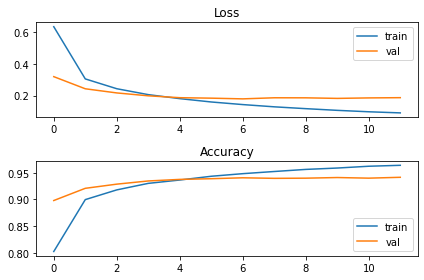

In [43]:
# plot loss during training
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()

plt.tight_layout()
plt.show()

In [44]:
del model

In [46]:
from keras.models import load_model

# returns a compiled model
# identical to the previous one
model = load_model('custom-model-letters-best.h5')

In [ ]:
type(history)

tensorflow.python.keras.callbacks.History

In [50]:
import pandas

In [51]:
pandas.DataFrame(history.history).to_csv("history-custom-model-letters-best.csv")

In [48]:
tmp = model.evaluate(test_X, test_y)
print("[test loss, test accuracy]:", tmp)

650/650 [==============================] - 1s 2ms/step - loss: 0.1943 - accuracy: 0.9388
[test loss, test accuracy]: [0.19427143037319183, 0.9387500286102295]
